In [607]:
%load_ext autoreload
%autoreload 2

import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling.physical_models import BlackBody
import astropy.units as u
import astropy.constants as const


environments = [NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43),
                NLTE.NLTE_model.Environment(T_phot= 2750, photosphere_velocity= 0.190, line_velocity= 0.190, t_d=3.41)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[<NLTE.NLTE_model.CollisionProcess object at 0x7f393413c700>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f393413c9a0>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f39338135b0>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f3931c51ab0>]
[<NLTE.NLTE_model.CollisionProcess object at 0x7f3934188f40>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f39312cd510>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f39312cdb40>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f39312cdd50>]


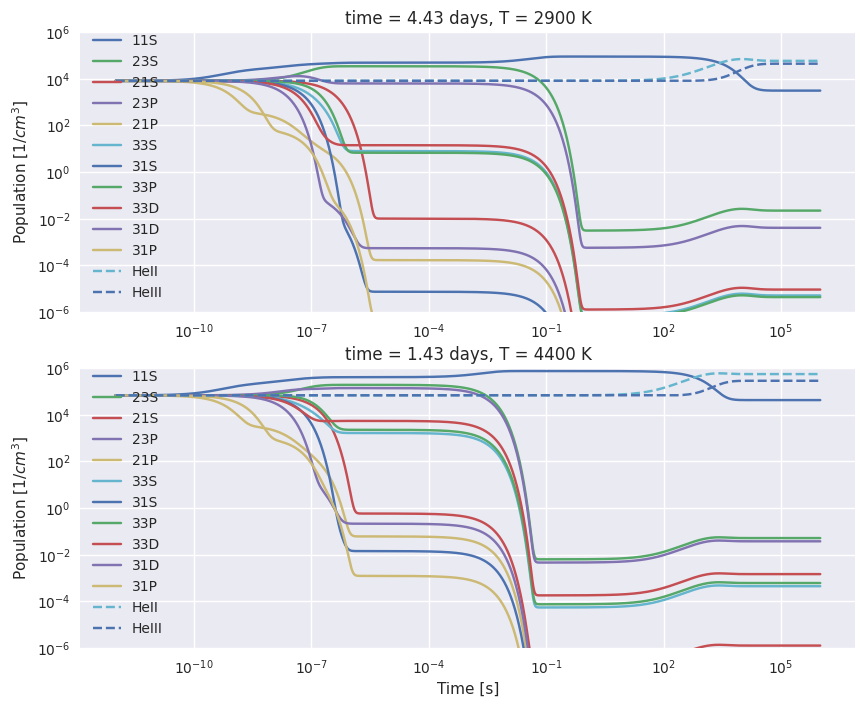

In [665]:
fig, axes = plt.subplots(2, 1, figsize=(10,8))
states = NLTE.NLTE_model.States()
for environment, ax in zip(environments, axes):
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
    nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
    print(nlte_solver.processes)
    t, y = nlte_solver.solve(np.geomspace(1e-12,1000000, 1000))
    ax.plot(t, y.T[:, :-2], label = states.names);
    ax.plot(t, y.T[:, -2:], linestyle="--", label  = ["HeII", "HeIII"]);
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel(r"Population $[1/cm^3]$")
    ax.set_ylim(1e-6, 1e6)
    ax.legend(loc="lower left")
    ax.set_title(f"time = {environment.t_d} days, T = {environment.T_phot} K")
    #for name, amount in zip(states.names + ["HeII", "HeIII"], y.T[-1]):
    #    print(name, amount)
ax.set_xlabel("Time [s]")
plt.savefig("plots/time_evolution.png", dpi=300, bbox_inches="tight")

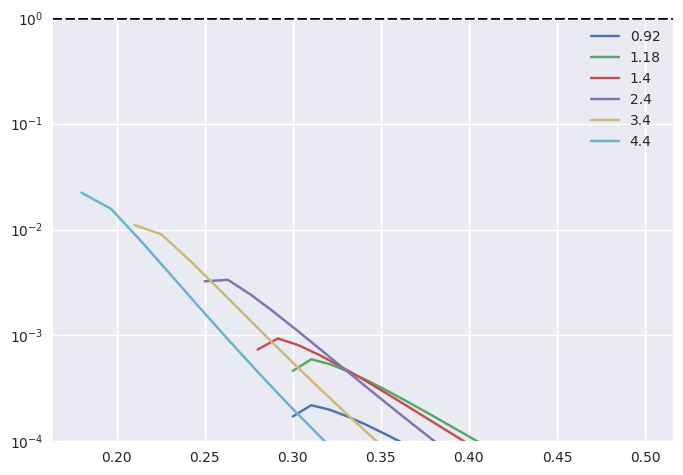

In [644]:

parameters = [{"T_phot": 5400, "photosphere_velocity": 0.3, "t_d": 0.92},
              {"T_phot": 4400, "photosphere_velocity": 0.3, "t_d": 1.18},
              {"T_phot": 4200, "photosphere_velocity": 0.28, "t_d": 1.4},
              {"T_phot": 3300, "photosphere_velocity": 0.25, "t_d": 2.4},
              {"T_phot": 3000, "photosphere_velocity": 0.21, "t_d": 3.4},
              {"T_phot": 2900, "photosphere_velocity": 0.18, "t_d": 4.4},
              ]
density_table = []
for params in parameters:
    velocities = np.linspace(params["photosphere_velocity"], 0.5, 20)
    densities = []
    for v in velocities:
        environment  = NLTE.NLTE_model.Environment(**params, line_velocity= v)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
        densities.append(nlte_solver.solve(1e7)[1][:, -1])
    density_table.append(np.array(densities))
    densities = np.array(densities)
    plt.plot(velocities, densities[:,1]/(7.4*params["t_d"]**-1), label = params["t_d"]);
    plt.yscale("log")
    plt.axhline(1, linestyle="--", color="black")
    #plt.xscale("log")
    plt.ylim(1e-4, 1e0)
    plt.legend()
    #for name, amount in zip(states.names + ["HeII", "HeIII"], y.T[-1]):
    #    print(name, amount)

In [610]:
import pickle
density_table = np.array(density_table)
pickle.dump({"densities":density_table, "parameters" : parameters, "states" : nlte_solver.states}, open("densities.pkl", "wb"))


In [611]:
import astropy.units as u
(4 * u.u).cgs

<Quantity 6.64215627e-24 g>

In [612]:

# demonstrate how to open the pickle file
import pickle
data = pickle.load(open("densities.pkl", "rb"))
data["densities"] # shape: (times, velocities, species)
data["parameters"] # dictionary of parameters  
data["states"] # list of species names
velocities = np.linspace(data["parameters"][0]["photosphere_velocity"], 0.5, 20)

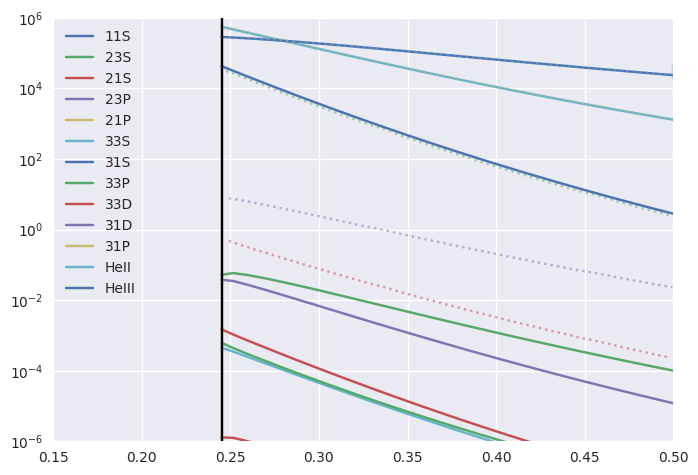

In [620]:
states = NLTE.NLTE_model.States()
velocities = np.linspace(0.245, 0.5, 40)
densities = []
for v in velocities:
    environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= v, t_d=1.43)
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
    nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
    densities.append(nlte_solver.solve(1e7)[1][:, -1])

    
for name, amount in zip(states.all_names, np.array(densities).T):
    plt.plot(velocities, amount, label=name)
plt.yscale("log")
plt.legend()
plt.ylim(1e-6, 1e6)


tarumi_states = ["11S", "23P", "23S", "He+", "He2+"]
for name in tarumi_states:
    velocity_23S, pops_23S = np.loadtxt(f"Tarumi_densities/Early{name}.csv", unpack=True, delimiter=";")
    plt.plot(velocity_23S, pops_23S, label=name, alpha=0.5, linestyle=":")
plt.xlim(0.15, 0.5)
plt.axvline(0.245, linestyle="-", color="black")

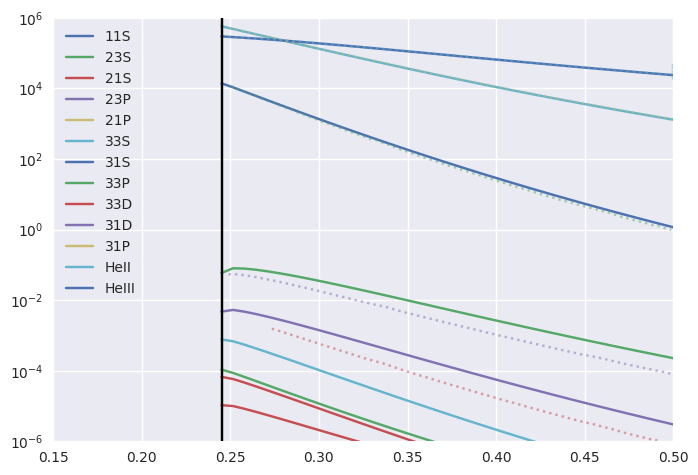

In [545]:
states = NLTE.NLTE_model.States()
velocities = np.linspace(0.245, 0.5, 40)
densities = []
for v in velocities:
    environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= v, t_d=1.43)
    #environment.spectrum = BlackBody(environment.spectrum.temperature, scale=0.*environment.spectrum.scale)
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
    #nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
    nlte_solver.processes = nlte_solver.processes[1:]
    densities.append(nlte_solver.solve(1e7)[1][:, -1])

    
for name, amount in zip(states.all_names, np.array(densities).T):
    plt.plot(velocities, amount, label=name)
plt.yscale("log")
plt.legend()
plt.ylim(1e-6, 1e6)


tarumi_states = ["11Swithout", "23Pwithout", "23Swithout", "He+", "He2+"]
for name in tarumi_states:
    velocity_23S, pops_23S = np.loadtxt(f"Tarumi_densities/Early{name}.csv", unpack=True, delimiter=";")
    plt.plot(velocity_23S, pops_23S, label=name, alpha=0.5, linestyle=":")
plt.xlim(0.15, 0.5)
plt.axvline(0.245, linestyle="-", color="black")

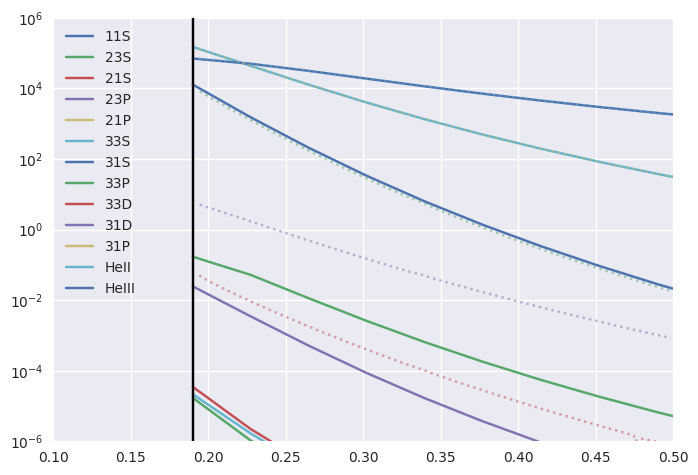

In [614]:
states = NLTE.NLTE_model.States()
velocities = np.linspace(0.19, 0.9, 20)
densities = []
for v in velocities:
    #states = NLTE.NLTE_model.States().filter(["11S", "23S", "21S", "23P", "21P", "33S"])
    environment  = NLTE.NLTE_model.Environment(T_phot= 2750, photosphere_velocity= 0.19, line_velocity= v, t_d= 3.41)
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment)#, states=states)
    nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
    densities.append(nlte_solver.solve(1e7)[1][:, -1])

for name, amount in zip(states.all_names, np.array(densities).T):
    plt.plot(velocities, amount, label=name)
plt.yscale("log")
plt.legend()
plt.ylim(1e-6, 1e6)

tarumi_states = ["11S", "23P", "23S", "He+", "He2+"]
for name in tarumi_states:
    velocity_23S, pops_23S = np.loadtxt(f"Tarumi_densities/late{name}.csv", unpack=True, delimiter=";")
    plt.plot(velocity_23S, pops_23S, label=name, alpha=0.5, linestyle=":")
plt.xlim(0.1, 0.5)
plt.axvline(0.19, linestyle="-", color="black")

[<NLTE.NLTE_model.CollisionProcess object at 0x7f393a564880>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f393a5160e0>, <NLTE.NLTE_model.PhotoionizationProcess object at 0x7f393b486c80>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f393feb3400>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f393b6508e0>]


(0.001, 1000.0)

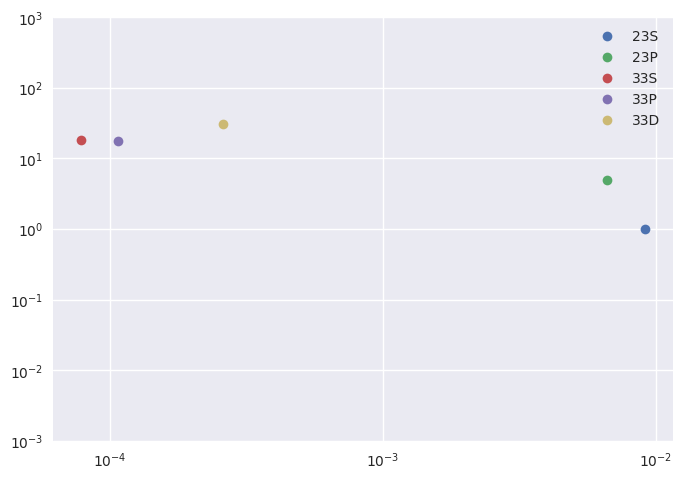

In [621]:
environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43)
#environment.spectrum = BlackBody(environment.spectrum.temperature, scale=0.*environment.spectrum.scale)
nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
print(nlte_solver.processes)
nlte_solver.processes = nlte_solver.processes[:3] + nlte_solver.processes[3:]
density = nlte_solver.solve(1e7)[1][:, -1]

p_i = states.multiplicities * np.exp(-(states.energies - states.energies[1]) / (const.k_B * 4400*u.K))
p_i = p_i * density[1] / p_i[1]
for name, amount, expected in zip(states.all_names[1:], density[1:-2], p_i[1:]):
    if name[1] == "3":
        plt.loglog(amount, amount/expected, "o", label=name)
plt.legend()
plt.ylim(1e-3, 1e3)

removed:  []
[<NLTE.NLTE_model.CollisionProcess object at 0x7f393b6503a0>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f393d32f6d0>, <NLTE.NLTE_model.PhotoionizationProcess object at 0x7f39396188e0>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f3939618880>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f39390fb700>]
Density in ortho:  1.0
Density in para:  1.0
Density ionized:  1.0


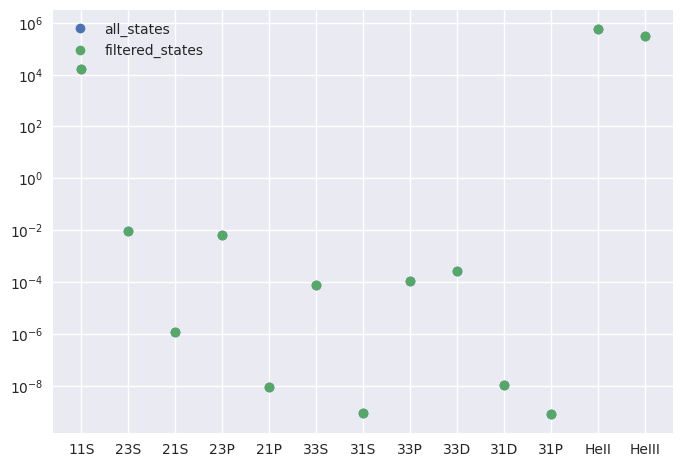

In [622]:
all_states = NLTE.NLTE_model.States()
states_filtered = all_states.filter(["11S", "21S", "21P", "31D", "31P", "31S", "23S", "23P"])
print("removed: ", np.setdiff1d(all_states.all_names, states.all_names))
environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43)
nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
print(nlte_solver.processes)
#nlte_solver.processes = nlte_solver.processes[:3] + nlte_solver.processes[3:]
densities_total = nlte_solver.solve(1e7)[1][:,-1]

environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43)
nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states=states)
nlte_solver.processes = nlte_solver.processes[:3] + nlte_solver.processes[3:]

densities = nlte_solver.solve(1e7)[1][:,-1]
ortho_filter = np.array([name[1] == "3" for name in states.all_names])
para_filter = np.array([name[1] == "1" for name in states.all_names])
ionized_filter = np.array([name[1] == "e" for name in states.all_names])
ortho_filter_total = np.array([name[1] == "3" for name in all_states.all_names])
para_filter_total = np.array([name[1] == "1" for name in all_states.all_names])
ionized_filter_total = np.array([name[1] == "e" for name in all_states.all_names])
print("Density in ortho: " , sum(densities_total[ortho_filter_total])/sum(densities[ortho_filter]))
print("Density in para: " , sum(densities_total[para_filter_total])/sum(densities[para_filter]))
print("Density ionized: " , sum(densities_total[ionized_filter_total])/sum(densities[ionized_filter]))
plt.plot(all_states.all_names, densities_total, "o", label="all_states")
plt.plot(states.all_names, densities, "o", label="filtered_states")
plt.legend()
plt.yscale("log")

(<Quantity [9.86268572e-08, 9.77840587e-08, 8.40330700e-08, 6.97757743e-08,
            5.77615753e-08, 4.81524335e-08, 4.05473588e-08, 3.45056044e-08,
            2.96625222e-08, 2.57386934e-08, 2.25248680e-08, 1.98648491e-08,
            1.76414517e-08, 1.57659967e-08, 1.41706967e-08, 1.28031875e-08,
            1.16225973e-08, 1.05967036e-08, 9.69985991e-09, 8.91146933e-09,
            8.21485015e-09, 7.59638415e-09, 7.04487114e-09, 6.55103533e-09,
            6.10714441e-09, 5.70671313e-09, 5.34427084e-09, 5.01517770e-09,
            4.71547845e-09, 4.44178518e-09, 4.19118275e-09, 3.96115208e-09,
            3.74950748e-09, 3.55434523e-09, 3.37400116e-09, 3.20701545e-09,
            3.05210333e-09, 2.90813052e-09, 2.77409263e-09, 2.64909772e-09,
            2.53235159e-09, 2.42314520e-09, 2.32084395e-09, 2.22487856e-09,
            2.13473711e-09, 2.04995831e-09, 1.97012559e-09, 1.89486200e-09,
            1.82382579e-09, 1.75670653e-09] kg / (rad2 s2)>,
 <Quantity [9.86268572e-08,

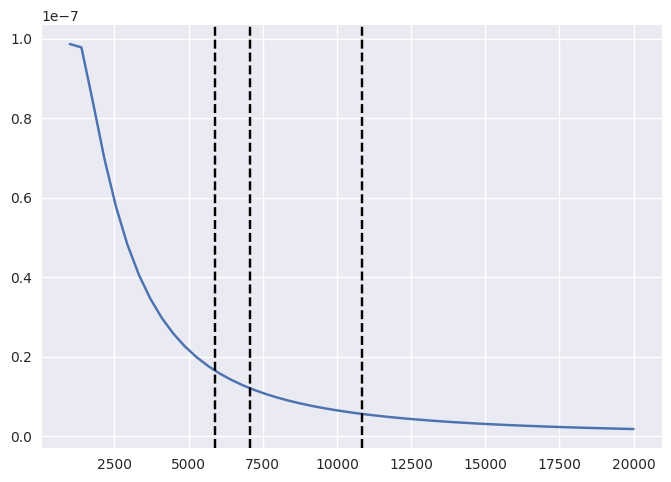

In [623]:
wl = np.linspace(1000, 20000, 50) * u.nm
nu = wl.to(u.Hz, equivalencies=u.spectral())
plt.plot(wl, NLTE.NLTE_model.Environment().spectrum(nu).si)
#plt.plot(wl, (2*u.h*nu**3/const.c**2/(np.exp(const.h*nu/(const.k_B*4400*u.K))-1)).si)
plt.axvline(10833, linestyle="--", color="black")
plt.axvline(7067, linestyle="--", color="black")
plt.axvline(5877, linestyle="--", color="black")
(2*const.h*nu**3/const.c**2/(np.exp(const.h*nu/(const.k_B*4400*u.K))-1) /(1 * u.sr) * 2*np.pi).si, NLTE.NLTE_model.Environment().spectrum(nu).si

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[<NLTE.NLTE_model.CollisionProcess object at 0x7f3937a1bcd0>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f3937a19a50>, <NLTE.NLTE_model.PhotoionizationProcess object at 0x7f3935d72980>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f393b6feb30>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f3935fb1240>]


/tmp/ipykernel_826/1033414874.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(1e-6, 0)


Text(0, 0.5, 'fluxes (events/cm^3/s)')

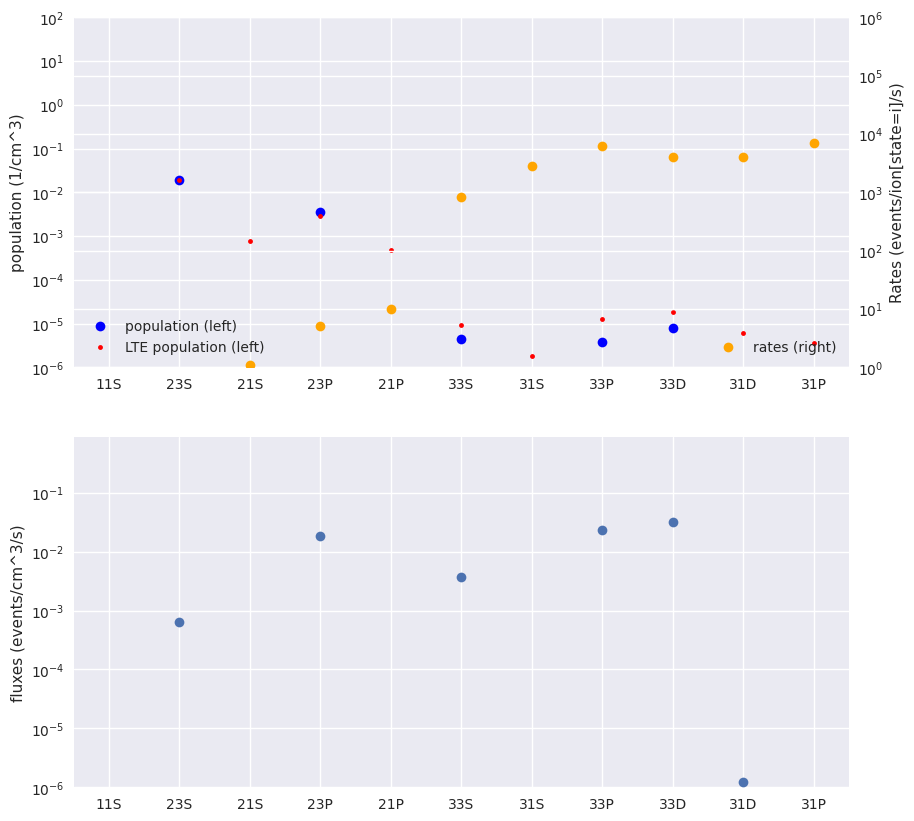

In [640]:
nlte_solver = NLTE.NLTE_model.NLTESolver( environments[0])
nlte_solver.processes = nlte_solver.processes
t, y = nlte_solver.solve(1e6)
print(nlte_solver.processes)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))

ax1_left  = ax1
ax1_left.semilogy(nlte_solver.states.names, y[:-2, -1], "o", label="population (left)", color="blue")
p_i = nlte_solver.states.multiplicities * np.exp(-nlte_solver.states.energies / (const.k_B * 4400*u.K))
p_i = p_i * y[1, -1] / p_i[1]
ax1_left.plot(nlte_solver.states.names,  p_i, ".", label="LTE population (left)", color="red")
ax1_left.legend(loc="lower left")
ax1_left.set_ylim(1e-6, 1e2)
ax1_left.set_ylabel("population (1/cm^3)")
ax1_right = ax1.twinx()
ax1_right.semilogy(nlte_solver.states.names, nlte_solver.processes[2].get_transition_rate_matrix()[-2, :-2], "o", label="rates (right)", color="orange")
ax1_right.legend(loc="lower right")
ax1_right.set_ylim(1e0, 1e6)
ax1_right.set_ylabel("Rates (events/ion[state=i]/s)")

ax2.semilogy(nlte_solver.states.names, (nlte_solver.processes[2].get_transition_rate_matrix()[-2,:-2] * y[:-2, -1]), "o")
ax2.legend()
ax2.set_ylim(1e-6, 0)
ax2.set_ylabel("fluxes (events/cm^3/s)")

Radiative                : 23P  -> 11S . Flux: 3.13e-01
Radiative                : 33D  -> 21P . Flux: 1.21e-01
Photoionization          : 33D  -> HeII. Flux: 3.23e-02
Photoionization          : 33P  -> HeII. Flux: 2.32e-02
Radiative                : 23P  -> 31D . Flux: 1.95e-02
Photoionization          : 23P  -> HeII. Flux: 1.82e-02
Collision                : 23P  -> 21S . Flux: 1.06e-02
Collision                : 23S  -> 21S . Flux: 9.86e-03
Collision                : 23P  -> 21P . Flux: 8.51e-03
Photoionization          : 33S  -> HeII. Flux: 3.78e-03
Collision                : 23S  -> 11S . Flux: 7.34e-04
Radiative                : 23S  -> 21P . Flux: 6.54e-04
Photoionization          : 23S  -> HeII. Flux: 6.45e-04
Radiative                : 23P  -> 21S . Flux: 3.23e-04
Radiative                : 33P  -> 31D . Flux: 1.00e-04


/tmp/ipykernel_826/4116308455.py:48: RuntimeWarning: divide by zero encountered in log10
  widths = np.clip(np.log10(process_fluxes/max_flux)+dynamic_range, 0, 10)/dynamic_range*6


Photoionization          : 33D  -> HeII. Flux: 1.17e+01
Photoionization          : 33P  -> HeII. Flux: 8.42e+00
Photoionization          : 23P  -> HeII. Flux: 6.93e+00
Radiative                : 33D  -> 21P . Flux: 4.10e+00
Photoionization          : 33S  -> HeII. Flux: 1.35e+00
Radiative                : 23P  -> 31D . Flux: 6.49e-01
Radiative                : 23P  -> 11S . Flux: 5.84e-01
Photoionization          : 23S  -> HeII. Flux: 3.14e-01
Collision                : 23P  -> 21P . Flux: 1.77e-01
Collision                : 23P  -> 21S . Flux: 1.49e-01
Collision                : 23S  -> 21S . Flux: 1.10e-01
Collision                : 33D  -> 31P . Flux: 9.92e-03
Collision                : 33S  -> 31S . Flux: 8.04e-03
Collision                : 33D  -> 31D . Flux: 6.53e-03
Collision                : 33D  -> 21P . Flux: 6.48e-03


/tmp/ipykernel_826/4116308455.py:48: RuntimeWarning: divide by zero encountered in log10
  widths = np.clip(np.log10(process_fluxes/max_flux)+dynamic_range, 0, 10)/dynamic_range*6


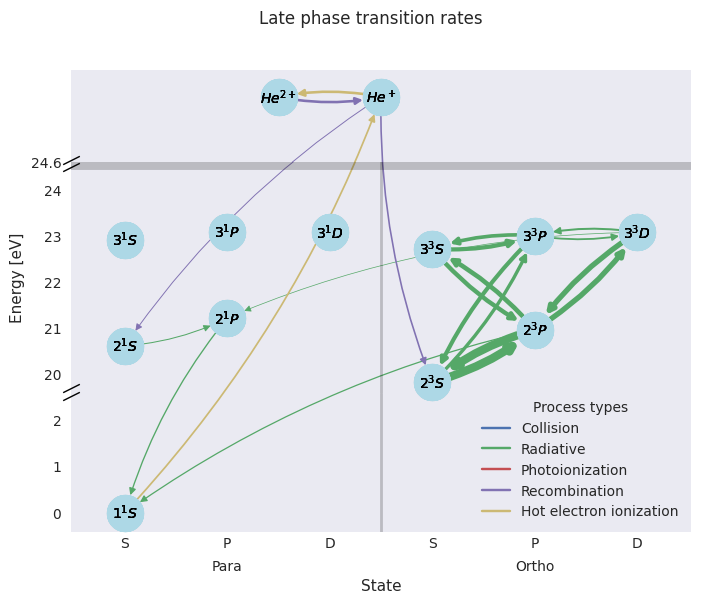

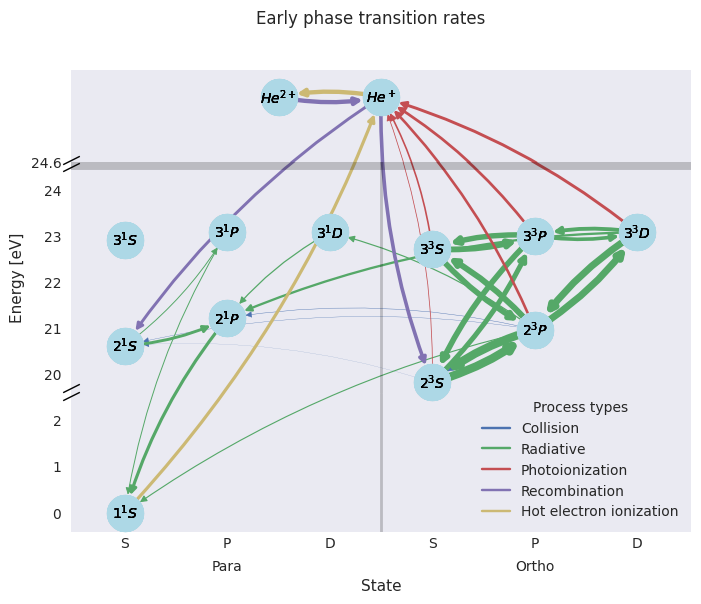

In [691]:
import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator


import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('seaborn-v0_8')

print_count = 15

# A_{i,j} = rate to state i from state j 
environments  = [NLTE.NLTE_model.Environment(T_phot= 2900, photosphere_velocity= 0.19, line_velocity=  0.19, t_d=4.43),
                 NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43),]
for environment in environments:
        #plt.figure(figsize=(8,6))
        # make subplots with the second one being taller
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [1, 2.5, 1.5]})
        plt.subplots_adjust(wspace=0, hspace=0)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
        nlte_solver.processes = nlte_solver.processes
        t, y = nlte_solver.solve(1e6)
        all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
        all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
        max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
        i = 0
        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                        i += 1
                        if i > print_count:
                                break
                        print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")

        max_flux = np.max(all_fluxes)
        for i, process in enumerate(nlte_solver.processes):
                process_fluxes = (process.get_transition_rate_matrix() * y.T[-1][None,:]).T

                # give nodes the names states.names + ["HeII", "HeIII"]
                order= [0,2,4,6,9, 10,1, 3, 5, 7, 8, 11, 12]
                #order = np.arange(len(states.names) + 2)
                dynamic_range = 6
                widths = np.clip(np.log10(process_fluxes/max_flux)+dynamic_range, 0, 10)/dynamic_range*6
                #widths = np.clip(process_fluxes/max_flux * 5, 0, 10)
                G = nx.DiGraph(widths)
                # rename nodes:
                labels = {i:name for i, name in enumerate(np.array(nlte_solver.states.all_names))}
                G = nx.relabel_nodes(G, labels)
                weights = nx.get_edge_attributes(G,'weight').values()
                pos = {"11S": (0,-3), "21S": (0, 1), "31S": (0, 2),
                                      "21P": (1, 0), "31P": (1, 1), 
                                                     "31D": (2, 0), 
                                      "23S": (3, 1), "33S": (3, 2),
                                      "23P": (4, 0), "33P": (4, 1), 
                                                     "33D": (5, 0), 
                       }
                final_pos = {name: (pos[name][0], energy.value) for name, energy in zip(nlte_solver.states.all_names, nlte_solver.states.energies)} 
                final_pos["HeII"] = (2.5, 26)
                final_pos["HeIII"] = (1.5, 26)
                final_pos["11S"] = 0, 17
                labels = {name: f"${name[0]}^{name[1]}{name[2]}$" for name in nlte_solver.states.all_names}
                labels["HeII"] = "$He^+$"
                labels["HeIII"] = "$He^{2+}$"
                #pos = nx.circular_layout(G)
                for ax in [ax1, ax2, ax3]:
                        nx.draw(G, final_pos, ax=ax,
                                width=list(weights),
                                edge_color=f'C{i}' ,connectionstyle="arc3,rad=0.1",
                                with_labels=True, labels=labels, 
                                node_color='lightblue', node_size=700, font_size=10, font_weight="light",)
                plt.plot([],[], color=f'C{i}', label=f'{process.name}')
        ax3.set_ylim(16.59, 19.59)
        ax2.set_ylim(19.59, 24.59)
        ax2.axhline(24.59, linestyle="-", linewidth=10, alpha=0.2, color="black")
        ax2.axvline(2.5, linestyle="-", linewidth=2, alpha=0.2, color="black")
        ax3.axvline(2.5, linestyle="-", linewidth=2, alpha=0.2, color="black")
        ax1.set_ylim(24.59, 26.59)
        
        ax1.spines.bottom.set_visible(False)
        ax2.spines.top.set_visible(False)
        ax2.spines.bottom.set_visible(False)
        ax3.spines.top.set_visible(False)

        ax1.axis("on")
        ax2.axis("on")
        ax3.axis("on")
        ax2.tick_params(left=True, labelleft=True)
        ax3.tick_params(left=True, labelleft=True, labelbottom=True, bottom=True, which="both")
        
        d = .5  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax2.plot([0], [0.02], transform=ax2.transAxes, **kwargs)
        ax3.plot([0], [0.98], transform=ax3.transAxes, **kwargs)
        ax1.plot([0], [0.02], transform=ax1.transAxes, **kwargs)
        ax2.plot([0], [0.98], transform=ax2.transAxes, **kwargs)
        ax2.set_ylabel("Energy [eV]")
        ax3.set_xlabel("State")
        ax3.set_yticks([final_pos["11S"][1], final_pos["11S"][1]+1, final_pos["11S"][1]+2])
        ax3.set_yticklabels(["0", "1", "2"])
        ax2.set_yticks(list(ax2.get_yticks()[1:-1]) + [24.6])
        ax2.set_yticklabels([str(x).removesuffix(".0") for x in ax2.get_yticks()])
        plt.legend(loc="lower right", title="Process types")
        ax3.tick_params(axis='x', which='major', pad=20)
        ax3.set_xticks([1.001, 3.999])
        ax3.set_xticklabels(["Para", "Ortho"])
        ax3.minorticks_on()
        ax3.set_xticks([0, 1, 2, 3, 4, 5], minor=True)

        ax3.set_xticklabels(["S", "P", "D", "S", "P", "D"], minor=True)
        #plt.setp(ax.get_xticklabels(), rotation=0)

        ax1.grid()
        ax2.grid()
        ax3.grid()
        if environment.t_d < 3:
                plt.suptitle("Early phase transition rates")

        else:
                plt.suptitle("Late phase transition rates")
        plt.savefig(f"transition_rates_{environment.t_d}.pdf", bbox_inches="tight")
        plt.savefig(f"transition_rates_{environment.t_d}.png", bbox_inches="tight", dpi=300)

Radiative                : 23P  -> 11S . Flux: 3.13e-01
Radiative                : 33D  -> 21P . Flux: 1.21e-01
Photoionization          : 33D  -> HeII. Flux: 3.23e-02
Photoionization          : 33P  -> HeII. Flux: 2.32e-02
Radiative                : 23P  -> 31D . Flux: 1.95e-02
Photoionization          : 23P  -> HeII. Flux: 1.82e-02
Collision                : 23P  -> 21S . Flux: 1.06e-02
Collision                : 23S  -> 21S . Flux: 9.86e-03
Collision                : 23P  -> 21P . Flux: 8.51e-03
Photoionization          : 33S  -> HeII. Flux: 3.78e-03
Collision                : 23S  -> 11S . Flux: 7.34e-04
Radiative                : 23S  -> 21P . Flux: 6.54e-04
Photoionization          : 23S  -> HeII. Flux: 6.45e-04
Radiative                : 23P  -> 21S . Flux: 3.23e-04
Radiative                : 33P  -> 31D . Flux: 1.00e-04


/tmp/ipykernel_826/268981856.py:51: RuntimeWarning: divide by zero encountered in log10
  widths = np.clip(np.log10(process_fluxes/max_flux)+dynamic_range, 0, 10)/dynamic_range*6


Photoionization          : 33D  -> HeII. Flux: 1.17e+01
Photoionization          : 33P  -> HeII. Flux: 8.42e+00
Photoionization          : 23P  -> HeII. Flux: 6.93e+00
Radiative                : 33D  -> 21P . Flux: 4.10e+00
Photoionization          : 33S  -> HeII. Flux: 1.35e+00
Radiative                : 23P  -> 31D . Flux: 6.49e-01
Radiative                : 23P  -> 11S . Flux: 5.84e-01
Photoionization          : 23S  -> HeII. Flux: 3.14e-01
Collision                : 23P  -> 21P . Flux: 1.77e-01
Collision                : 23P  -> 21S . Flux: 1.49e-01
Collision                : 23S  -> 21S . Flux: 1.10e-01
Collision                : 33D  -> 31P . Flux: 9.92e-03
Collision                : 33S  -> 31S . Flux: 8.04e-03
Collision                : 33D  -> 31D . Flux: 6.53e-03
Collision                : 33D  -> 21P . Flux: 6.48e-03


/tmp/ipykernel_826/268981856.py:51: RuntimeWarning: divide by zero encountered in log10
  widths = np.clip(np.log10(process_fluxes/max_flux)+dynamic_range, 0, 10)/dynamic_range*6


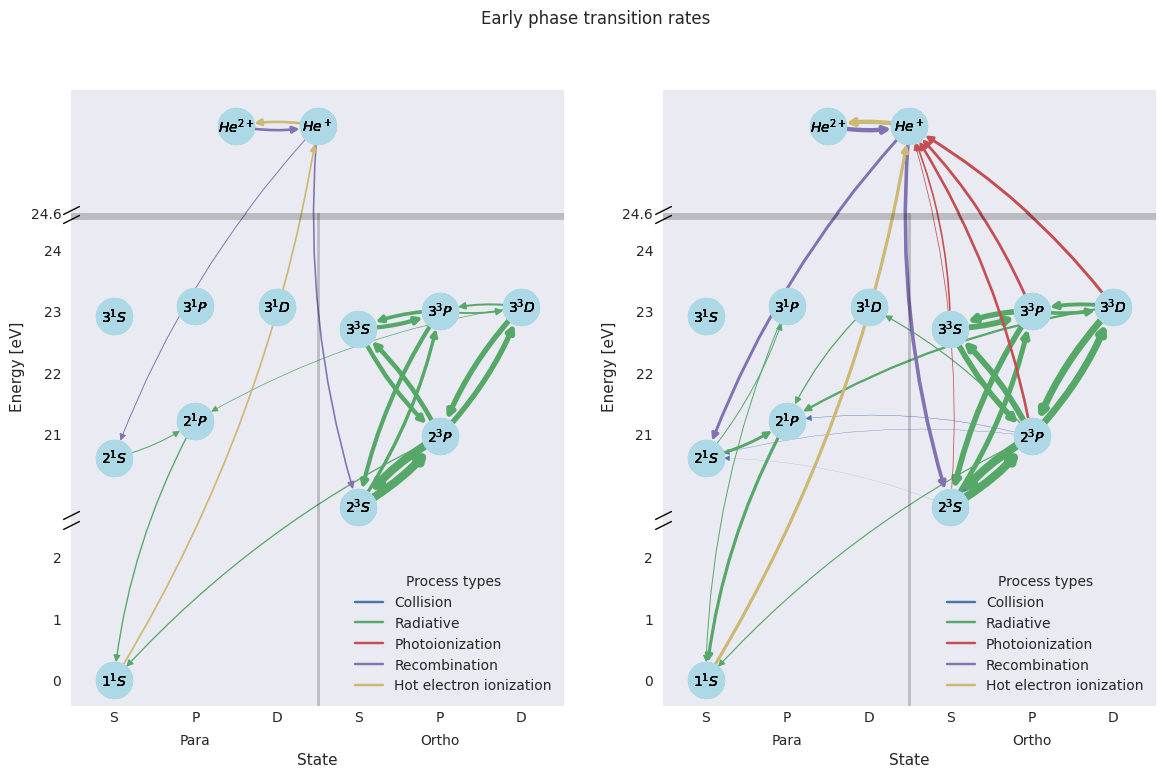

In [708]:
import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator


import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('seaborn-v0_8')

print_count = 15

# A_{i,j} = rate to state i from state j 
environments  = [NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43),
                 NLTE.NLTE_model.Environment(T_phot= 2900, photosphere_velocity= 0.19, line_velocity=  0.19, t_d=4.43)]
fig, axes = plt.subplots(3, 2, sharex="col", sharey="row", figsize=(14,8), gridspec_kw={'height_ratios': [1, 2.5, 1.5]})
plt.subplots_adjust( hspace=0)

for environment, (ax1, ax2, ax3), title in zip(environments, [axes[:,0], axes[:,1]], ["Early phase [1.43 days]", "Late phase [4.43 days]"]):
        #plt.figure(figsize=(8,6))
        # make subplots with the second one being taller
        #fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [1, 2.5, 1.5]})
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
        nlte_solver.processes = nlte_solver.processes
        t, y = nlte_solver.solve(1e6)
        all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
        all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
        max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
        i = 0
        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                        i += 1
                        if i > print_count:
                                break
                        print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")

        max_flux = np.max(all_fluxes)
        legend_array = []
        for i, process in enumerate(nlte_solver.processes):
                process_fluxes = (process.get_transition_rate_matrix() * y.T[-1][None,:]).T

                # give nodes the names states.names + ["HeII", "HeIII"]
                order= [0,2,4,6,9, 10,1, 3, 5, 7, 8, 11, 12]
                #order = np.arange(len(states.names) + 2)
                dynamic_range = 6
                widths = np.clip(np.log10(process_fluxes/max_flux)+dynamic_range, 0, 10)/dynamic_range*6
                #widths = np.clip(process_fluxes/max_flux * 5, 0, 10)
                G = nx.DiGraph(widths)
                # rename nodes:
                labels = {i:name for i, name in enumerate(np.array(nlte_solver.states.all_names))}
                G = nx.relabel_nodes(G, labels)
                weights = nx.get_edge_attributes(G,'weight').values()
                pos = {"11S": (0,-3), "21S": (0, 1), "31S": (0, 2),
                                      "21P": (1, 0), "31P": (1, 1), 
                                                     "31D": (2, 0), 
                                      "23S": (3, 1), "33S": (3, 2),
                                      "23P": (4, 0), "33P": (4, 1), 
                                                     "33D": (5, 0), 
                       }
                final_pos = {name: (pos[name][0], energy.value) for name, energy in zip(nlte_solver.states.all_names, nlte_solver.states.energies)} 
                final_pos["HeII"] = (2.5, 26)
                final_pos["HeIII"] = (1.5, 26)
                final_pos["11S"] = 0, 17
                labels = {name: f"${name[0]}^{name[1]}{name[2]}$" for name in nlte_solver.states.all_names}
                labels["HeII"] = "$He^+$"
                labels["HeIII"] = "$He^{2+}$"
                #pos = nx.circular_layout(G)
                for ax in [ax1, ax2, ax3]:
                        nx.draw(G, final_pos, ax=ax,
                                width=list(weights),
                                edge_color=f'C{i}' ,connectionstyle="arc3,rad=0.1",
                                with_labels=True, labels=labels, 
                                node_color='lightblue', node_size=700, font_size=10, font_weight="light",)
                legend_array.append(ax3.plot([],[], color=f'C{i}', label=f'{process.name}'))
        ax3.set_ylim(16.59, 19.59)
        ax2.set_ylim(19.59, 24.59)
        ax2.axhline(24.59, linestyle="-", linewidth=10, alpha=0.2, color="black")
        ax2.axvline(2.5, linestyle="-", linewidth=2, alpha=0.2, color="black")
        ax3.axvline(2.5, linestyle="-", linewidth=2, alpha=0.2, color="black")
        ax1.set_ylim(24.59, 26.59)
        
        ax1.spines.bottom.set_visible(False)
        ax2.spines.top.set_visible(False)
        ax2.spines.bottom.set_visible(False)
        ax3.spines.top.set_visible(False)

        ax1.axis("on")
        ax2.axis("on")
        ax3.axis("on")
        ax2.tick_params(left=True, labelleft=True)
        ax3.tick_params(left=True, labelleft=True, labelbottom=True, bottom=True, which="both")
        
        d = .5  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax2.plot([0], [0.02], transform=ax2.transAxes, **kwargs)
        ax3.plot([0], [0.98], transform=ax3.transAxes, **kwargs)
        ax1.plot([0], [0.02], transform=ax1.transAxes, **kwargs)
        ax2.plot([0], [0.98], transform=ax2.transAxes, **kwargs)
        ax2.set_ylabel("Energy [eV]")
        ax3.set_xlabel("State")
        ax3.set_yticks([final_pos["11S"][1], final_pos["11S"][1]+1, final_pos["11S"][1]+2])
        ax3.set_yticklabels(["0", "1", "2"])
        ax2.set_yticks(list(ax2.get_yticks()[1:-1]) + [24.6])
        ax2.set_yticklabels([str(x).removesuffix(".0") for x in ax2.get_yticks()])
        ax3.legend(loc="lower right", title="Process types")
        ax3.tick_params(axis='x', which='major', pad=20)
        ax3.set_xticks([1.001, 3.999])
        ax3.set_xticklabels(["Para", "Ortho"])
        ax3.minorticks_on()
        ax3.set_xticks([0, 1, 2, 3, 4, 5], minor=True)

        ax3.set_xticklabels(["S", "P", "D", "S", "P", "D"], minor=True)
        #plt.setp(ax.get_xticklabels(), rotation=0)

        ax1.grid()
        ax2.grid()
        ax3.grid()
        if environment.t_d < 3:
                ax1.suptitle("Early phase transition rates")

        else:
                plt.suptitle("Late phase transition rates")
        plt.savefig(f"transition_rates_{environment.t_d}.pdf", bbox_inches="tight")
        plt.savefig(f"transition_rates_{environment.t_d}.png", bbox_inches="tight", dpi=300)

In [703]:
axes

array([[<Axes: >, <Axes: >],
       [<Axes: ylabel='Energy [eV]'>, <Axes: ylabel='Energy [eV]'>],
       [<Axes: xlabel='State'>, <Axes: xlabel='State'>]], dtype=object)

In [688]:
str(ax2.get_yticks()[-1]).strip(".0")

'24.6'

In [670]:
ax2.get_yticks()

array([44.58, 45.58, 46.58, 47.58, 48.58])

In [626]:
import pandas as pd

get_n = lambda n, l, count: (int(n)-1)*2 if count else (int(n)-1)
nist_table = pd.read_csv("atomic data/A_rates_NIST.csv")
def get_state_name(config_series, term_series):
    n = config_series.str.findall("([\d+]+)([spdf])(2?)").apply(lambda x: str(1+sum([get_n(*nlm) for nlm in x])))
    term = term_series.str.strip("=\"*")
    return n+term

lower_state = get_state_name(nist_table["conf_i"], nist_table["term_i"])
upper_state = get_state_name(nist_table["conf_k"], nist_table["term_k"])
A_coefficients = pd.to_numeric(nist_table["Aki(s^-1)"].str.strip("=\"*"))
names = states.names
A_matrix = np.zeros((len(names), len(names)))

df = pd.DataFrame({"lower_state": lower_state, "upper_state": upper_state, "A_coefficients": A_coefficients, "multiplicity": nist_table["g_i"]})
for (lower, upper), A in df.groupby(["lower_state", "upper_state"]):
    weighted_A = np.average(A["A_coefficients"], weights=A["multiplicity"])
    if lower in names and upper in names:
        A_matrix[names.index(lower),names.index(upper)] = weighted_A
df[df["lower_state"].apply(lambda x: x[1] == "3" and x[0] in "123") & (df["upper_state"].apply(lambda x: x[1] == "1" and x[0] in "123"))]

,lower_state,upper_state,A_coefficients,multiplicity
149,23P,31D,4310.000000,5
150,23P,31D,12320.000000,3
200,23S,21P,1.442000,3
730,13G,11H,1577.000000,11
800,13G,11H,2527.000000,11
...,...,...,...,...
2154,13K,11I,6.858000,13
2163,13I,11H,19.750000,11
2172,13H,11G,50.390000,9
2235,33D,31P,0.039860,5


In [627]:
ortho_filter = np.array([name[1] == "3" for name in states.all_names])
print_count = 10

for environment in environments:
    print(f"t_d = {environment.t_d}\n\n\n")
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
    all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
    all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
    max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
    i = 0
    for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
        if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
            i += 1
            if i > print_count:
                break
            print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")
                

t_d = 4.43



Radiative                : 33D  -> 21P . Flux: 3.93e+00
Photoionization          : 33D  -> HeII. Flux: 1.05e+00
Photoionization          : 33P  -> HeII. Flux: 6.54e-01
Radiative                : 23P  -> 11S . Flux: 5.84e-01
Photoionization          : 33S  -> HeII. Flux: 6.63e-02
Radiative                : 23P  -> 31D . Flux: 3.64e-02
Photoionization          : 23P  -> HeII. Flux: 3.39e-02
Collision                : 23P  -> 21S . Flux: 1.98e-02
Collision                : 23P  -> 21P . Flux: 1.59e-02
Collision                : 23S  -> 21S . Flux: 4.64e-03
t_d = 1.43



Photoionization          : 33D  -> HeII. Flux: 1.17e+01
Photoionization          : 33P  -> HeII. Flux: 8.42e+00
Photoionization          : 23P  -> HeII. Flux: 6.93e+00
Radiative                : 33D  -> 21P . Flux: 4.10e+00
Photoionization          : 33S  -> HeII. Flux: 1.35e+00
Radiative                : 23P  -> 31D . Flux: 6.49e-01
Radiative                : 23P  -> 11S . Flux: 5.84e-01
Photoionization     

In [628]:
max_index

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 1, 1, 3, 4, 1, 2, 3, 1, 2, 2,
        1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2, 0, 2, 1,
        0, 1, 1, 2, 1, 4, 4, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 4, 4, 0, 4, 4, 1, 2, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [629]:
triplet_filer = np.array([x[1] == "3" for x in nlte_solver.states.all_names])

#(nlte_solver.get_transition_rate_matrix() * y.T[-1][None,:]), nlte_solver.states
y.T[-1][triplet_filer], np.array(nlte_solver.states.all_names)[triplet_filer]

(array([9.09810416e-03, 6.61123149e-03, 7.84030344e-05, 1.07028879e-04,
        2.59216338e-04]),
 array(['23S', '23P', '33S', '33P', '33D'], dtype='<U5'))

In [630]:
ax.xaxis.get_ticklocs(minor=True)     # []


array([0, 1, 2, 3, 4, 5])

In [631]:
labels = {name: f"${name[0]}*{name[1]}{name[2]}" for name in nlte_solver.states.all_names}


for process Collision the max flux into ortho states is 0.0003513301951331578, which is from state 21S to state 23S
for process Radiative the max flux into ortho states is 7.988703702960401e-05, which is from state 31D to state 23P
for process Photoionization the max flux into ortho states is 0.0, which is from state 11S to state 23S
for process Recombination the max flux into ortho states is 34.518156163687124, which is from state HeII to state 23S
for process Hot electron ionization the max flux into ortho states is 0.0, which is from state 11S to state 23S


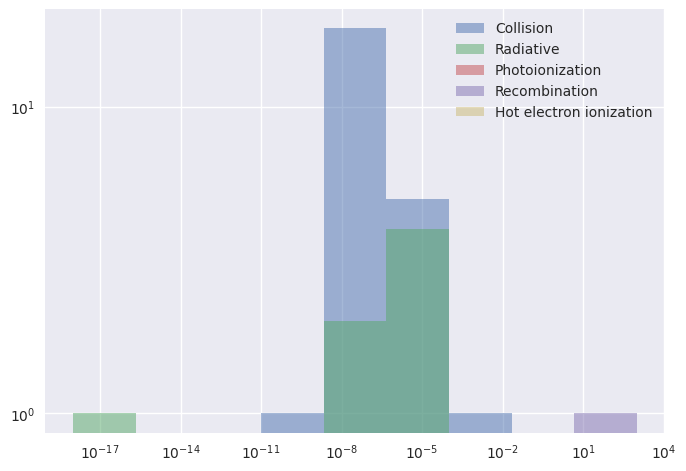

for process Collision the max flux out of ortho states is 0.17730134687276852, which is from state 23P to state 21P
for process Radiative the max flux out of ortho states is 4.099793584585509, which is from state 33D to state 21P
for process Photoionization the max flux out of ortho states is 11.662562054982729, which is from state 33D to state HeII
for process Recombination the max flux out of ortho states is 0.0, which is from state 23S to state 11S
for process Hot electron ionization the max flux out of ortho states is 9.524952210135047e-06, which is from state 23S to state HeII


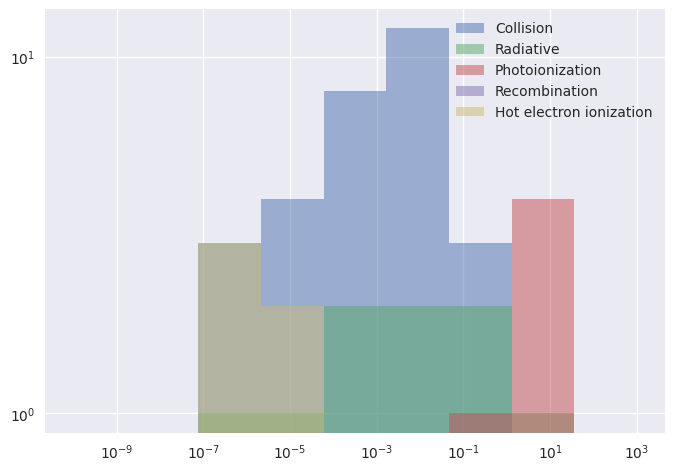

In [632]:
# make histogram of the flux sizes for each process
environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43)
nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
#nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
t, y = nlte_solver.solve(1000000)

ortho_states = np.array([name[1] == "3" for name in nlte_solver.states.all_names])
for process in nlte_solver.processes:
    fluxes =  process.get_transition_rate_matrix()* y.T[-1][None,:] 
    in_fluxes = fluxes[ortho_states, :][:, ~ortho_states]
    idx = np.unravel_index(np.argmax(in_fluxes), in_fluxes.shape)
    plt.hist(in_fluxes.flatten(), bins=np.geomspace(1e-18, 1000, 10), label=process.name, alpha=0.5, histtype="stepfilled")
    print(f"for process {process.name} the max flux into ortho states is {np.max(in_fluxes)}, which is from state {np.array(nlte_solver.states.all_names)[~ortho_states][idx[1]]} to state {np.array(nlte_solver.states.all_names)[ortho_states][idx[0]]}")

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()
for process in nlte_solver.processes:
    fluxes =  process.get_transition_rate_matrix()* y.T[-1][None,:] 
    out_fluxes = fluxes[~ortho_states, :][:, ortho_states]
    idx = np.unravel_index(np.argmax(out_fluxes), out_fluxes.shape)
    plt.hist(out_fluxes.flatten(), bins=np.geomspace(1e-10, 1000, 10), label=process.name, alpha=0.5, histtype="stepfilled")
    print(f"for process {process.name} the max flux out of ortho states is {np.max(out_fluxes)}, which is from state {np.array(nlte_solver.states.all_names)[ortho_states][idx[1]]} to state {np.array(nlte_solver.states.all_names)[~ortho_states][idx[0]]}")
plt.legend()
plt.xscale("log")
plt.yscale("log")

In [633]:
nlte_solver.processes[1].get_A_rates()[nlte_solver.states.all_names.index("11S"), nlte_solver.states.all_names.index("23P")]
nlte_solver.processes[1].get_A_rates()[nlte_solver.states.all_names.index("23P"), nlte_solver.states.all_names.index("33D")]
nlte_solver.processes[1].get_A_rates()[nlte_solver.states.all_names.index("21P"), nlte_solver.states.all_names.index("33P")]

0.0

nlte_solver.processes[1].get_A_rates()[nlte_solver.states.all_names.index("21S"), nlte_solver.states.all_names.index("23P")]

In [634]:
nlte_solver.processes[1].get_A_rates()[nlte_solver.states.all_names.index("11S"), nlte_solver.states.all_names.index("23P")]


88.3635

In [635]:
import pandas
def get_A_rates(self):
    get_n = lambda n, l, count: (int(n)-1)*2 if count else (int(n)-1)
    nist_table = pandas.read_csv("atomic data/A_rates_NIST.csv")
    def get_state_name(config_series, term_series):
        n = config_series.str.findall("([\d+]+)([spdf])(2?)").apply(lambda x: str(1+sum([get_n(*nlm) for nlm in x])))
        term = term_series.str.strip("=\"*")
        return n+term

    lower_state = get_state_name(nist_table["conf_i"], nist_table["term_i"])
    upper_state = get_state_name(nist_table["conf_k"], nist_table["term_k"])

    A_coefficients = np.zeros((len(self.states.names), len(self.states.names)))

    for state_name in self.states.names:
        selection = (i_state == state_i) & (j_state.isin(names)) & (nist_table["Aki(s^-1)"] != '=""')
        selected_A = nist_table[selection]["Aki(s^-1)"].str.strip("=\"*")
        for state_j, A in zip(j_state[selection], selected_A):
            A_coefficients[self.states.names.index(state_i),self.states.names.index(state_j)] = float(A)
    
    A_coefficients[names.index("11S"), names.index("23P")] = 1.764e+02# 1.764e+02 	#3.27e-1
    """
    A_coefficients[names.index("11S"), names.index("23P")] = 0# 1.764e+02 	#3.27e-1
    A_coefficients[names.index("23P"), names.index("31D")] = 0# 1.764e+02 	#3.27e-1
    A_coefficients[names.index("21P"), names.index("33D")] = 0# 1.764e+02 	#3.27e-1
    A_coefficients[names.index("21P"), names.index("23S")] = 0# 1.764e+02 	#3.27e-1
    A_coefficients[names.index("31D"), names.index("33P")] = 0# 1.764e+02 	#3.27e-1
    """
    """
    # F. Drake 1969
    drake_coeff = {"11S": {"21S": 5.13e1}}#, "23S": 4.02e-9}}
    for state_i, subtable in drake_coeff.items():
        if state_i not in states:
            continue
        for state_j, coeff in subtable.items():
            if state_j not in states:
                continue
            A_coefficients[states.index(state_i),states.index(state_j)] = coeff
    """
    return A_coefficients

A_coefficients = get_A_rates(nlte_solver.processes[1])

NameError: name 'i_state' is not defined

In [636]:

get_n = lambda n, l, count: (int(n)-1)*2 if count else (int(n)-1)
nist_table = pandas.read_csv("atomic data/A_rates_NIST.csv")
def get_state_name(config_series, term_series):
    n = config_series.str.findall("([\d+]+)([spdf])(2?)").apply(lambda x: str(1+sum([get_n(*nlm) for nlm in x])))
    term = term_series.str.strip("=\"*")
    return n+term

lower_state = get_state_name(nist_table["conf_i"], nist_table["term_i"])
upper_state = get_state_name(nist_table["conf_k"], nist_table["term_k"])
A_coefficients = pandas.to_numeric(nist_table["Aki(s^-1)"].str.strip("=\"*"))
#names = self.states.names
names = NLTE.NLTE_model.States().names
A_matrix = np.zeros((len(names), len(names)))

df = pandas.DataFrame({"lower_state": lower_state, "upper_state": upper_state, "A_coefficients": A_coefficients, "multiplicity": nist_table["g_i"]})
for (lower, upper), A in df.groupby(["lower_state", "upper_state"]):
    weighted_A = np.average(A["A_coefficients"], weights=A["multiplicity"])
    if lower in names and upper in names:
        A_matrix[names.index(lower),names.index(upper)] = weighted_A
filter = (lower_state == "11S") & (upper_state == "23S")
nist_table[filter]

,obs_E(eV),unc_obs_E,ritz_wn(eV),unc_ritz_wn,intens,Aki(s^-1),Acc,Ei(eV),Ek(eV),conf_i,...,J_i,conf_k,term_k,J_k,g_i,g_k,Type,tp_ref,line_ref,Unnamed: 20
28,"=""""","=""""","=""19.81961453""","=""0.00000014""","=""""","=""1.272e-04""",AA,"=""[0.00000000]""","=""[19.819614525]""","=""1s2""",...,"=""0""","=""1s.2s""","=""3S""","=""1""",1,3,M1,"=""T1896""","=""""",NaN


23S,
 R=34.50313378822811,
 LTE pop: 1.0000000000000027
33S,
 R=17168.956144965712,
 LTE pop: 0.000479878275890534
43S,
 R=70902.7464847399,
 LTE pop: 4.7704588274753024e-05
53S,
 R=103503.74700369328,
 LTE pop: 1.761656325507962e-05
23P,
 R=1048.6791890513987,
 LTE pop: 0.14346164067182304
33P,
 R=78659.87864230057,
 LTE pop: 0.0006676808619992026
43P,
 R=236340.37548158737,
 LTE pop: 0.00010565393082269495
53P,
 R=322413.1211368099,
 LTE pop: 4.5476645510285486e-05
33D,
 R=44991.61649415416,
 LTE pop: 0.0009413462692994294
43D,
 R=170591.72287779755,
 LTE pop: 0.00016403234078191136
53D,
 R=256430.2184784581,
 LTE pop: 7.309473470621564e-05
43F,
 R=69738.34758614737,
 LTE pop: 0.00022914513082653346
53F,
 R=151779.96720212008,
 LTE pop: 0.00010221214598846233
53A,
 R=49361.153597481214,
 LTE pop: 0.00013137421933605194


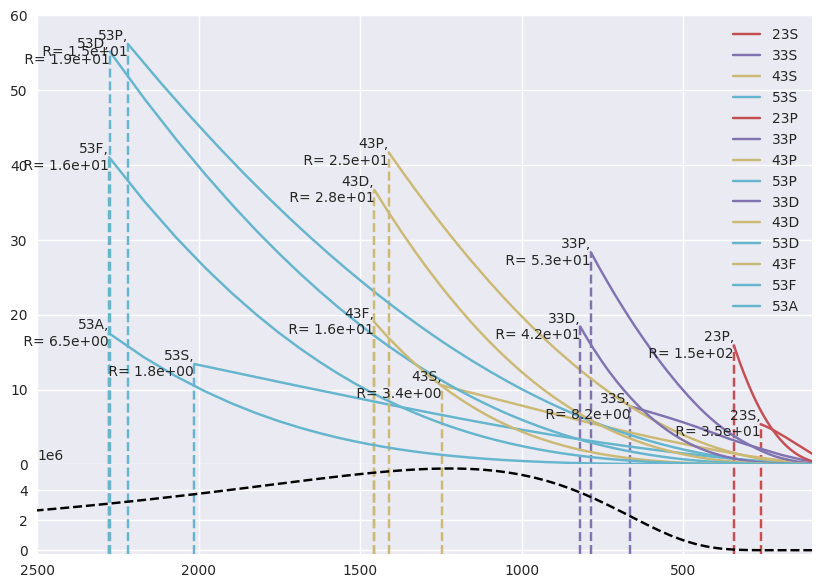

In [649]:
import NLTE.NLTE_model
ionization_rates = []
ionization_dict = NLTE.NLTE_model.get_ionization_dict()
spectrum = NLTE.NLTE_model.Environment().spectrum
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,7), sharex=True, height_ratios=[5, 1])
i = 0
for state in ionization_dict.keys():
    if not (state[0] in "12345" and state[1] == "3"):
        continue
    energies, crossection = ionization_dict[state]
    E = (energies * u.Ry).cgs
    nu = E.to(u.Hz, equivalencies=u.spectral()) 
    sigma = (crossection * u.Mbarn).cgs
    ionization_flux_article = u.sr * sigma
    x = E.to("nm", equivalencies=u.spectral()).value
    ax1.plot(x, crossection, label=state, color=f"C{state[0]}") 
    ax1.plot([x[0],x[0]], [0,crossection[0]], linestyle="--", color=f"C{state[0]}")
    ax2.axvline(x[[0]], linestyle="--", color=f"C{state[0]}")

    g = ("SPDFA".index(state[2])) *2 + 1
    lte_pop = g * np.exp(-(-E[0] + 0.3503019 * u.Ry)/(const.k_B*4400*u.K))
    ionization_flux_article = u.sr * sigma * (spectrum(nu)/E)
    print(f"{state},\n R={np.trapz(x=nu, y=ionization_flux_article).to(1/u.s).value},\n LTE pop: {lte_pop.value}")
    ax1.text(x[[0]], crossection[0], f"{state},\n R={lte_pop*np.trapz(x=nu, y=ionization_flux_article).to(1/u.s).value: 1.1e}", verticalalignment="center", horizontalalignment="right")
    i+=1


nm_range = np.linspace(100, 4000, 100) * u.nm
spectrum = BlackBody(3000 * u.K, scale=2*np.pi*u.Unit("erg/(s nm sr cm2)")) 
ax2.plot(nm_range, spectrum(nm_range)/nm_range.to("eV", equivalencies = u.spectral()), "--", color="black", alpha=1)
#spectrum = BlackBody(4400 * u.K, scale=2*np.pi*u.Unit("erg/(s nm sr cm2)")) 
#ax2.plot(nm_range, spectrum(nm_range)/nm_range.to("eV", equivalencies = u.spectral()), "--", color="black", alpha=1)

ax1.legend()
ax1.set_ylim(0, 6e1)
ax1.set_xlim(2500, 100)
plt.subplots_adjust(wspace=0, hspace=0)
#ax1.yscale("log")
# plot spectrum on right axis
#plt.yscale("log")
#plt.ylim(0, 1e-1)

In [600]:
E[0]

<Quantity 8.71973795e-13 erg>